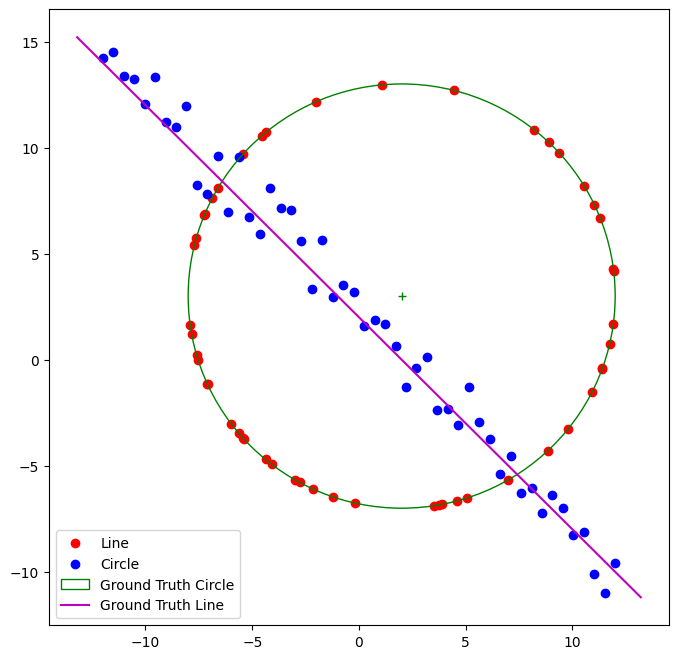

In [3]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
#import tikzplotlib

np.random.seed(0)
N=100
half_n=N//2
r=10
x0_gt,y0_gt = 2,3 #center
s =r/16
t=np.random.uniform(0,2*np.pi,half_n)
n = np.random.randn(half_n)
x,y=x0_gt+r*np.cos(t),y0_gt+r*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
s=1
m,b=-1,2
x=np.linspace(-12,12,half_n)
y= m*x+b+s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X=np.vstack((X_circ,X_line))

fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.scatter(X_circ[:,0],X_circ[:,1],c='r',label='Line')
ax.scatter(X_line[:,0],X_line[:,1],c='b',label='Circle')
circle_gt=plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt),(y0_gt),'+',color='g')
x_min,x_max = ax.get_xlim()
x_ =np.array([x_min,x_max])
y_ = m*x_+b
plt.plot(x_,y_,color='m',label='Ground Truth Line')
plt.legend()
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.564330975072617e-09
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
rex.x:  [0.87414445 0.48566604 3.99226809]
Iteration =  0 . No. inliners =  13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0576378329713795e-07
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
rex.x:  [0.7907409  0.61215118 1.76063541]
Iteration =  1 . No. inliners =  28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.291587188345638
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5
[0.76175263 0.64786798 1.78376622] 4.291587188345638
A better model found ...  [0.76175263 0.64786798 1.78376622] 4.291587188345638
Optimization terminated successfully    (Exit mode 0)
            Current functi

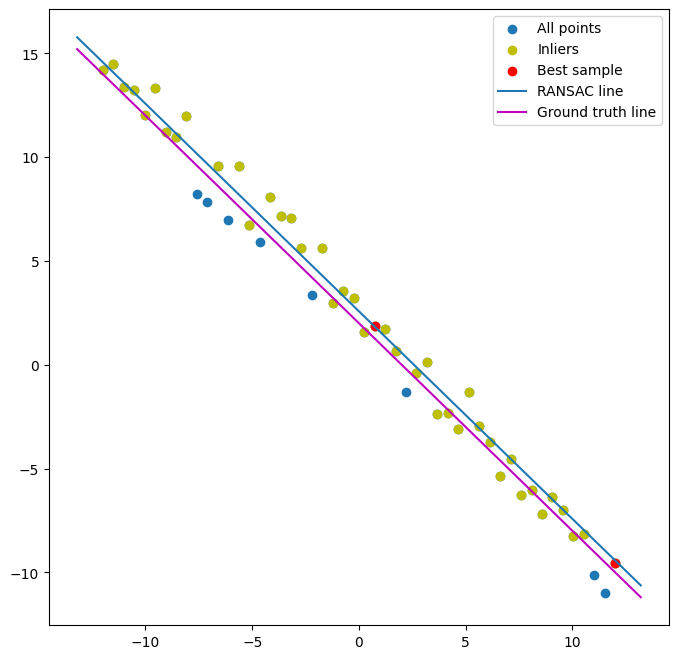

In [9]:
import math
N = X_line.shape[0]
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Function to fit a line to two points
def fit_line(points):
    a, b = points
    if a[0] == b[0]:
        # Vertical line
        direction = np.array([0, 1])
    else:
        direction = b - a
    # Normalize the direction vector
    direction /= np.linalg.norm(direction)
    return direction

# Function to calculate the distance from a point to a line
def distance_to_line(line, point):
    direction = line
    # Calculate the vector from a point on the line to the given point
    vector_to_point = point
    # Calculate the perpendicular distance
    distance = np.linalg.norm(np.cross(direction, vector_to_point))
    return distance

# RANSAC parameters
iterations = 1000  # Number of RANSAC iterations
threshold = 0.5  # Distance threshold for inlier/outlier classification
min_inliers = 20  # Minimum number of inliers required for a valid model

best_model = None
best_inliers = []

for _ in range(iterations):
    # Randomly select two points to fit the line
    sample_indices = np.random.choice(len(X), 2, replace=False)
    sample = X[sample_indices]
    
    # Fit a line to the selected points
    model = fit_line(sample)
    
    # Calculate the distance to the line for all points
    distances = np.array([distance_to_line(model, point) for point in X])
    
    # Identify inliers as points whose distance to the line is less than the threshold
    inliers = np.where(distances < threshold)[0]
    
    # Check if there are enough inliers
    if len(inliers) >= min_inliers:
        # Re-estimate the model using all inliers
        inlier_points = X[inliers]
        updated_model = fit_line(inlier_points)
        
        # Store the model with the most inliers
        if len(inliers) > len(best_inliers):
            best_model = updated_model
            best_inliers = inliers

# Refit the best model using all inliers
inlier_points = X[best_inliers]
final_model = fit_line(inlier_points)

# Plot the noisy data and the estimated line
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c='k', label='Noisy Data')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = final_model[1] + final_model[0] * x_range
ax.plot(x_range, y_range, 'r', label='Estimated Line')
plt.legend()
plt.show()

print("Estimated Line Direction (a, b):", final_model)


ValueError: not enough values to unpack (expected 2, got 0)